
![alt text](https://pbs.twimg.com/media/DilKBjUVsAA74j1.jpg)

## Background Data

- Where there is salt, there is oil.
- But where is the salt?
- Classifying seismic imaging currently requires human (salt/not salt)
- Can we use an algorithm to do this instead? (yes)
- Seismic data is like an ultra-sound of the subsurface
- It uses wavelengths around 1m to 100m
- The Society of Exploration Geophysicists has 10K publications using the keyword 'salt'
- We can think of Earth as layered.
- Sand gets deposited on top of existing sand. And in comes the salt.
- There is an entire research branch dedicated to salt tectonics, that is the movement of salt in the subsurface.

## Our steps

- Install Dependencies
- Upload our Dataset
- View the labeled seismic imaging data
- Plot the depth distribution in the training data 
- Plot the proportion of salt vs depth in the training data
- Build a U-Net algorithm to learn the mapping between seismic images and the salt filter mask


In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

#read/write image data
!pip install imageio
#deep learning library
!pip install torch
#access kaggle datasets from colab
!pip install kaggle
#model loading
!pip install ipywidgets

In [2]:
#File input output
import os
#matrix math
import numpy as np
#read/write image data
import imageio
#visualize data
import matplotlib.pyplot as plt
#data preprocessing 
import pandas as pd
#deep learning
import torch
#just in case we need a backup datasets
from torch.utils import data
#will output the plot right below the cell that produces it
%matplotlib inline

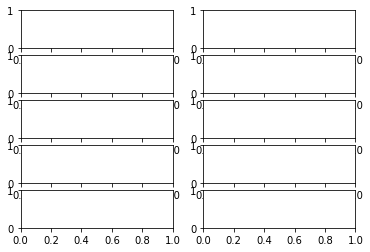

In [3]:
f, axarr = plt.subplots(5,2)

AttributeError: 'numpy.ndarray' object has no attribute 'showe'

In [3]:
#lets create a class to represent this data, to make it easier to access

class TGSSaltDataset(data.Dataset):
    #init with the location of the dataset, and the list of file 
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    #get method - how long is the list
    def __len__(self):
        return len(self.file_list)
    #get method - return the seismic image + label for a given index
    def __getitem__(self, index):
        #if the index is out of bounds, get a random image
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        #define a file ID using the index parameter
        file_id = self.file_list[index]
        #image folder + path
        image_folder = os.path.join(self.root_path, "images")
#         image_path = os.path.join(image_folder,"\\" +file_id + ".png")
        image_path=image_folder+"\\" +file_id + ".png"
        #label folder + path
        print(image_path)
        mask_folder = os.path.join(self.root_path, "masks")
#         mask_path = os.path.join(mask_folder, file_id + ".png")
        mask_path=mask_folder+"\\" +file_id + ".png"
        #read it, store it in memory as a byte array
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        #return image + label
        return image, mask

In [4]:
#train image + mask data
train_mask = pd.read_csv('D:\\Datasets\\tgs-salt-identification-challenge\\train.csv')
#depth data
depth = pd.read_csv('D:\\Datasets\\tgs-salt-identification-challenge\\depths.csv')
#training path
train_path = "D:\\Datasets\\tgs-salt-identification-challenge\\"

#list of files
file_list = list(train_mask['id'].values)
#define our dataset using our class
dataset = TGSSaltDataset(train_path, file_list)

In [5]:
#function to visualize these images
def plot2x2Array(image, mask):
    #invoke matplotlib!
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

D:\Datasets\tgs-salt-identification-challenge\images\22e7cc183f.png
D:\Datasets\tgs-salt-identification-challenge\images\5b435fad9d.png
D:\Datasets\tgs-salt-identification-challenge\images\2e7921981a.png
D:\Datasets\tgs-salt-identification-challenge\images\5e09ef27a6.png
D:\Datasets\tgs-salt-identification-challenge\images\45fb16d378.png


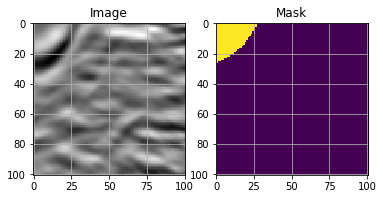

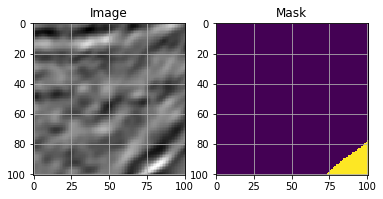

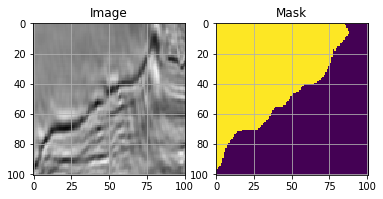

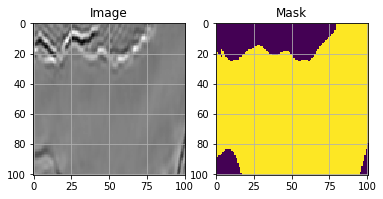

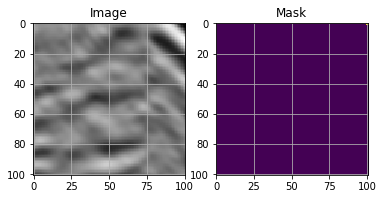

In [6]:
for i in range(5):
    image, mask = dataset[np.random.randint(0, len(dataset))]
    plot2x2Array(image, mask)

In [11]:
depth.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


In [12]:
train_mask.head()

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


Text(0.5, 1.0, 'Depth distribution')

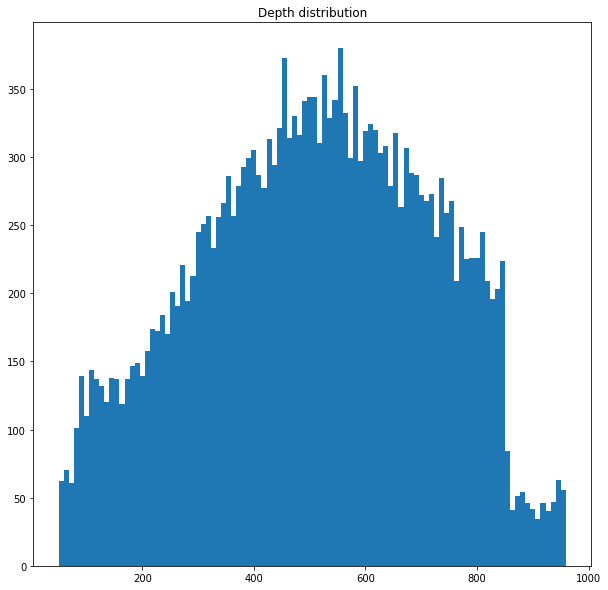

In [9]:
plt.figure(figsize = (10, 10))
plt.hist(depth['z'], bins = 100)
plt.title('Depth distribution')

Run-length encoding (RLE) is a very simple form of lossless data compression in which runs of data (that is, sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run. 

![alt text](https://sites.google.com/a/ruknuddin.com/inqilab-patel-magazine/_/rsrc/1525765922681/term-of-the-day/runlengthencoding/RunLengthEncoding.PNG)



In [16]:
#convert to image
def rleToMask(rleString,height,width):
    #width heigh
    rows,cols = height,width
    try:
        #get numbers
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        #get pairs
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        #create an image
        img = np.zeros(rows*cols,dtype=np.uint8)
        #for each pair
        for index,length in rlePairs:
            #get the pixel value 
            index -= 1
            img[index:index+length] = 255
        
        
        #reshape
        img = img.reshape(cols,rows)
        img = img.T
    
    #else return empty image
    except:
        img = np.zeros((cols,rows))
    
    return img

In [22]:
#for measuring how salty an image is
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        ## The total number of pixels is 101*101 = 10,201
        return counts[1]/10201.
    
    except: 
        return 0.0

In [23]:

salt_proportion(train_mask['mask'][1])

[  0 255] [5050 5151]


0.504950495049505

In [19]:
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x, 101,101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))

In [24]:
merged = train_mask.merge(depth, how = 'left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5, 1.0, 'Proportion of salt v. depth')

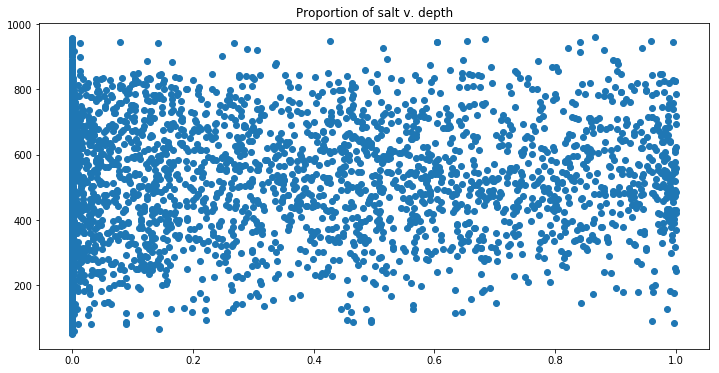

In [25]:
plt.figure(figsize = (12, 6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Proportion of salt v. depth')

In [13]:
print("Correlation: ", np.corrcoef(merged['salt_proportion'], merged['z'])[0, 1])


Correlation:  0.10361580365557439


#### U-Nets

- This looks like a computer vision problem!
- What outperforms everything else when it comes to computer vision most of the time? (hint deep learning)
- Specifically, deep convolutional neural networks.
- AlexNet
- VGG-16, VGG-19;
- Inception Nets;
- ResNet;
- Squeeze Net 

![alt text](https://pics.spark-in.me/upload/388373c74ab710cc4c429538d4779a93.png)
![alt text](https://pics.spark-in.me/upload/8b468c6dd60a499e6cdde0af803cb96f.png)

#### Why not use one of these, why use a U-Net?

- U-NET is considered one of standard architectures for image classification tasks, when we need not only to segment the whole image by its class, but also to segment areas of image by class, i.e. produce a mask that will separate image into several classes.
-its architecture is input image size agnostic since it does not contain fully connected layers 
- Because of many layers takes significant amount of time to train;
- U-Net is designed like an auto-encoder. 
- It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape.  
- However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. 
- For each pixel in the original image, it asks the question: “To which class does this pixel belong?
- This flexibility allows U-Net to predict different parts of the seismic image (salt, not salt) simultaneously.
- U-Net passes the feature maps from each level of the contracting path over to the analogous level in the expanding path.  
- These are similar to residual connections in a ResNet type model, and allow the classifier to consider features at various scales and complexities to make its decision.

#### What does a U-Net look like?

![alt text](https://cdn-images-1.medium.com/max/800/1*dKPBgCdJx6zj3MpED3lcNA.png)
![alt text](https://pics.spark-in.me/upload/cb8197bb7e57317eda88f921dfc1c413.png)

its high to low res, then low res to high res

- The first part (encoder) is where we apply convolutional blocks followed by a maxpool downsampling to encode the input image into feature representations at multiple different levels.

convolutions→ downsampling.

Example

```
# a sample down block
def make_conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
self.down1 = nn.Sequential(
    *make_conv_bn_relu(in_channels, 64, kernel_size=3, stride=1, padding=1 ),
    *make_conv_bn_relu(64, 64, kernel_size=3, stride=1, padding=1 ),
)

# convolutions followed by a maxpool
down1 = self.down1(x)
out1   = F.max_pool2d(down1, kernel_size=2, stride=2)

```

- The  second part (decoder) of the network consists of upsample and concatenation followed by regular convolution operations

upsampling → concatenation →convolutions.

```
# a sample up block
def make_conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
self.up4 = nn.Sequential(
    *make_conv_bn_relu(128,64, kernel_size=3, stride=1, padding=1 ),
    *make_conv_bn_relu(64,64, kernel_size=3, stride=1, padding=1 )
)
self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1, stride=1, padding=0 )

# upsample out_last, concatenate with down1 and apply conv operations
out   = F.upsample(out_last, scale_factor=2, mode='bilinear')  
out   = torch.cat([down1, out], 1)
out   = self.up4(out)

# final 1x1 conv for predictions
final_out = self.final_conv(out)
```




In [34]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf

In [35]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7676308536865335364
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3185940889
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5454384291857129578
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [36]:
im_width = 128
im_height = 128
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
#path_train = '../input/train/'
#path_test = '../input/test/'

In [37]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Join features information in the depthest layer
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
#check out this skip connection thooooo
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # The mean_iou metrics seens to leak train and test values...
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 128, 128, 8)  584         conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_59[0][0]                  
__________________________________________________________________________________________________
conv2d_60 

In [24]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + 'images\\' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + 'masks\\' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


  0%|                                                                                      | 0/4000 [00:00<?, ?it/s]D:\ML Workspace\Kaggle Workspace\TGS Salt Identification\TGS_Salt_Identification\lib\site-packages\keras_preprocessing\image\utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████████████████████████████████████████████████████████████████████| 4000/4000 [00:16<00:00, 236.07it/s]


Done!


In [38]:
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)
tensor_board = TensorBoard('./logs/model-tgs-salt-2')


In [39]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-2.h5', verbose=1, save_best_only=True, save_weights_only=False),
    tensor_board
]
results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/50
3400/3400 [==============================] - ETA: 2:53 - loss: 0.6940 - acc: 0.532 - ETA: 1:33 - loss: 0.6929 - acc: 0.577 - ETA: 1:07 - loss: 0.6921 - acc: 0.610 - ETA: 53s - loss: 0.6919 - acc: 0.602 - ETA: 45s - loss: 0.6916 - acc: 0.60 - ETA: 39s - loss: 0.6902 - acc: 0.63 - ETA: 35s - loss: 0.6895 - acc: 0.64 - ETA: 32s - loss: 0.6879 - acc: 0.66 - ETA: 30s - loss: 0.6876 - acc: 0.66 - ETA: 28s - loss: 0.6863 - acc: 0.67 - ETA: 26s - loss: 0.6842 - acc: 0.68 - ETA: 25s - loss: 0.6821 - acc: 0.70 - ETA: 24s - loss: 0.6814 - acc: 0.70 - ETA: 23s - loss: 0.6781 - acc: 0.71 - ETA: 22s - loss: 0.6764 - acc: 0.71 - ETA: 21s - loss: 0.6734 - acc: 0.72 - ETA: 20s - loss: 0.6702 - acc: 0.73 - ETA: 20s - loss: 0.6693 - acc: 0.73 - ETA: 19s - loss: 0.6661 - acc: 0.73 - ETA: 19s - loss: 0.6633 - acc: 0.73 - ETA: 18s - loss: 0.6593 - acc: 0.74 - ETA: 18s - loss: 0.6556 - acc: 0.74 - ETA: 17s - loss: 0.6515 - acc: 0.74 - ETA: 17s - loss:


Epoch 00001: val_loss improved from inf to 0.53950, saving model to model-tgs-salt-2.h5
Epoch 2/50
3400/3400 [==============================] - ETA: 11s - loss: 0.6167 - acc: 0.68 - ETA: 12s - loss: 0.5552 - acc: 0.74 - ETA: 12s - loss: 0.5505 - acc: 0.74 - ETA: 12s - loss: 0.5335 - acc: 0.76 - ETA: 12s - loss: 0.5557 - acc: 0.73 - ETA: 11s - loss: 0.5445 - acc: 0.74 - ETA: 11s - loss: 0.5376 - acc: 0.75 - ETA: 11s - loss: 0.5318 - acc: 0.76 - ETA: 11s - loss: 0.5252 - acc: 0.76 - ETA: 11s - loss: 0.5290 - acc: 0.76 - ETA: 11s - loss: 0.5352 - acc: 0.75 - ETA: 11s - loss: 0.5341 - acc: 0.76 - ETA: 11s - loss: 0.5365 - acc: 0.75 - ETA: 11s - loss: 0.5298 - acc: 0.76 - ETA: 11s - loss: 0.5301 - acc: 0.76 - ETA: 11s - loss: 0.5324 - acc: 0.76 - ETA: 11s - loss: 0.5260 - acc: 0.76 - ETA: 11s - loss: 0.5345 - acc: 0.76 - ETA: 11s - loss: 0.5395 - acc: 0.75 - ETA: 11s - loss: 0.5418 - acc: 0.75 - ETA: 11s - loss: 0.5508 - acc: 0.74 - ETA: 11s - loss: 0.5558 - acc: 0.74 - ETA: 11s - loss: 0.

Epoch 00002: val_loss improved from 0.53950 to 0.39574, saving model to model-tgs-salt-2.h5
Epoch 3/50
3400/3400 [==============================] - ETA: 11s - loss: 0.4136 - acc: 0.83 - ETA: 12s - loss: 0.5196 - acc: 0.75 - ETA: 12s - loss: 0.4965 - acc: 0.77 - ETA: 12s - loss: 0.4605 - acc: 0.79 - ETA: 12s - loss: 0.4412 - acc: 0.80 - ETA: 11s - loss: 0.4276 - acc: 0.81 - ETA: 11s - loss: 0.4166 - acc: 0.82 - ETA: 11s - loss: 0.4049 - acc: 0.83 - ETA: 11s - loss: 0.4062 - acc: 0.82 - ETA: 11s - loss: 0.3960 - acc: 0.83 - ETA: 11s - loss: 0.3923 - acc: 0.83 - ETA: 11s - loss: 0.3972 - acc: 0.83 - ETA: 11s - loss: 0.3999 - acc: 0.83 - ETA: 11s - loss: 0.4065 - acc: 0.82 - ETA: 11s - loss: 0.4123 - acc: 0.82 - ETA: 11s - loss: 0.4134 - acc: 0.82 - ETA: 11s - loss: 0.4220 - acc: 0.81 - ETA: 11s - loss: 0.4253 - acc: 0.81 - ETA: 11s - loss: 0.4194 - acc: 0.81 - ETA: 11s - loss: 0.4162 - acc: 0.81 - ETA: 11s - loss: 0.4162 - acc: 0.81 - ETA: 11s - loss: 0.4216 - acc: 0.81 - ETA: 11s - loss:

Epoch 00003: val_loss improved from 0.39574 to 0.35486, saving model to model-tgs-salt-2.h5
Epoch 4/50
3400/3400 [==============================] - ETA: 11s - loss: 0.3389 - acc: 0.85 - ETA: 11s - loss: 0.3198 - acc: 0.88 - ETA: 11s - loss: 0.3593 - acc: 0.85 - ETA: 11s - loss: 0.3440 - acc: 0.86 - ETA: 11s - loss: 0.3501 - acc: 0.86 - ETA: 11s - loss: 0.3361 - acc: 0.87 - ETA: 11s - loss: 0.3278 - acc: 0.87 - ETA: 11s - loss: 0.3332 - acc: 0.87 - ETA: 11s - loss: 0.3561 - acc: 0.86 - ETA: 11s - loss: 0.3460 - acc: 0.87 - ETA: 11s - loss: 0.3455 - acc: 0.87 - ETA: 11s - loss: 0.3397 - acc: 0.87 - ETA: 11s - loss: 0.3294 - acc: 0.87 - ETA: 11s - loss: 0.3188 - acc: 0.88 - ETA: 11s - loss: 0.3127 - acc: 0.88 - ETA: 11s - loss: 0.3121 - acc: 0.88 - ETA: 11s - loss: 0.3294 - acc: 0.87 - ETA: 11s - loss: 0.3403 - acc: 0.86 - ETA: 10s - loss: 0.3418 - acc: 0.86 - ETA: 10s - loss: 0.3396 - acc: 0.86 - ETA: 10s - loss: 0.3397 - acc: 0.86 - ETA: 10s - loss: 0.3358 - acc: 0.86 - ETA: 10s - loss:

Epoch 00004: val_loss improved from 0.35486 to 0.26283, saving model to model-tgs-salt-2.h5
Epoch 5/50
3400/3400 [==============================] - ETA: 11s - loss: 0.2931 - acc: 0.86 - ETA: 11s - loss: 0.2542 - acc: 0.88 - ETA: 11s - loss: 0.2630 - acc: 0.88 - ETA: 12s - loss: 0.2745 - acc: 0.88 - ETA: 11s - loss: 0.2980 - acc: 0.86 - ETA: 11s - loss: 0.2986 - acc: 0.86 - ETA: 12s - loss: 0.2790 - acc: 0.87 - ETA: 12s - loss: 0.2671 - acc: 0.88 - ETA: 12s - loss: 0.2703 - acc: 0.87 - ETA: 11s - loss: 0.2708 - acc: 0.87 - ETA: 11s - loss: 0.2651 - acc: 0.87 - ETA: 11s - loss: 0.2670 - acc: 0.87 - ETA: 11s - loss: 0.2700 - acc: 0.87 - ETA: 11s - loss: 0.2701 - acc: 0.87 - ETA: 11s - loss: 0.2702 - acc: 0.87 - ETA: 11s - loss: 0.2670 - acc: 0.87 - ETA: 11s - loss: 0.2725 - acc: 0.87 - ETA: 11s - loss: 0.2639 - acc: 0.88 - ETA: 11s - loss: 0.2660 - acc: 0.88 - ETA: 11s - loss: 0.2677 - acc: 0.88 - ETA: 11s - loss: 0.2637 - acc: 0.88 - ETA: 11s - loss: 0.2609 - acc: 0.88 - ETA: 11s - loss:

Epoch 00005: val_loss did not improve from 0.26283
Epoch 6/50
3400/3400 [==============================] - ETA: 12s - loss: 0.3444 - acc: 0.84 - ETA: 12s - loss: 0.2980 - acc: 0.87 - ETA: 12s - loss: 0.3203 - acc: 0.86 - ETA: 12s - loss: 0.3380 - acc: 0.85 - ETA: 11s - loss: 0.3250 - acc: 0.86 - ETA: 11s - loss: 0.3221 - acc: 0.86 - ETA: 12s - loss: 0.3151 - acc: 0.86 - ETA: 11s - loss: 0.3145 - acc: 0.86 - ETA: 11s - loss: 0.3176 - acc: 0.86 - ETA: 11s - loss: 0.3076 - acc: 0.86 - ETA: 11s - loss: 0.2967 - acc: 0.87 - ETA: 11s - loss: 0.2906 - acc: 0.87 - ETA: 11s - loss: 0.2773 - acc: 0.88 - ETA: 11s - loss: 0.2743 - acc: 0.88 - ETA: 11s - loss: 0.2723 - acc: 0.88 - ETA: 11s - loss: 0.2674 - acc: 0.88 - ETA: 11s - loss: 0.2656 - acc: 0.89 - ETA: 11s - loss: 0.2593 - acc: 0.89 - ETA: 11s - loss: 0.2638 - acc: 0.89 - ETA: 11s - loss: 0.2737 - acc: 0.88 - ETA: 11s - loss: 0.2790 - acc: 0.88 - ETA: 11s - loss: 0.2790 - acc: 0.88 - ETA: 10s - loss: 0.2748 - acc: 0.88 - ETA: 10s - loss: 0.


Epoch 00006: val_loss did not improve from 0.26283
Epoch 7/50
3400/3400 [==============================] - ETA: 11s - loss: 0.2812 - acc: 0.87 - ETA: 11s - loss: 0.3265 - acc: 0.85 - ETA: 11s - loss: 0.3622 - acc: 0.82 - ETA: 11s - loss: 0.3190 - acc: 0.85 - ETA: 11s - loss: 0.2942 - acc: 0.86 - ETA: 11s - loss: 0.2718 - acc: 0.87 - ETA: 11s - loss: 0.2857 - acc: 0.87 - ETA: 11s - loss: 0.2836 - acc: 0.87 - ETA: 11s - loss: 0.2812 - acc: 0.87 - ETA: 11s - loss: 0.2737 - acc: 0.88 - ETA: 11s - loss: 0.2685 - acc: 0.88 - ETA: 11s - loss: 0.2578 - acc: 0.89 - ETA: 11s - loss: 0.2532 - acc: 0.89 - ETA: 11s - loss: 0.2623 - acc: 0.88 - ETA: 11s - loss: 0.2647 - acc: 0.88 - ETA: 11s - loss: 0.2621 - acc: 0.88 - ETA: 11s - loss: 0.2646 - acc: 0.88 - ETA: 11s - loss: 0.2581 - acc: 0.88 - ETA: 11s - loss: 0.2517 - acc: 0.88 - ETA: 10s - loss: 0.2453 - acc: 0.89 - ETA: 10s - loss: 0.2557 - acc: 0.88 - ETA: 10s - loss: 0.2544 - acc: 0.89 - ETA: 10s - loss: 0.2505 - acc: 0.89 - ETA: 10s - loss: 0


Epoch 00007: val_loss improved from 0.26283 to 0.23233, saving model to model-tgs-salt-2.h5
Epoch 8/50
3400/3400 [==============================] - ETA: 11s - loss: 0.2137 - acc: 0.92 - ETA: 11s - loss: 0.2797 - acc: 0.90 - ETA: 11s - loss: 0.2639 - acc: 0.90 - ETA: 11s - loss: 0.2673 - acc: 0.89 - ETA: 11s - loss: 0.2441 - acc: 0.90 - ETA: 11s - loss: 0.2314 - acc: 0.91 - ETA: 11s - loss: 0.2294 - acc: 0.91 - ETA: 11s - loss: 0.2287 - acc: 0.91 - ETA: 11s - loss: 0.2241 - acc: 0.91 - ETA: 11s - loss: 0.2171 - acc: 0.91 - ETA: 11s - loss: 0.2324 - acc: 0.91 - ETA: 11s - loss: 0.2300 - acc: 0.91 - ETA: 11s - loss: 0.2270 - acc: 0.91 - ETA: 11s - loss: 0.2254 - acc: 0.91 - ETA: 11s - loss: 0.2207 - acc: 0.91 - ETA: 11s - loss: 0.2397 - acc: 0.90 - ETA: 11s - loss: 0.2380 - acc: 0.90 - ETA: 11s - loss: 0.2294 - acc: 0.91 - ETA: 11s - loss: 0.2445 - acc: 0.90 - ETA: 11s - loss: 0.2429 - acc: 0.90 - ETA: 11s - loss: 0.2460 - acc: 0.90 - ETA: 11s - loss: 0.2421 - acc: 0.90 - ETA: 10s - loss

Epoch 00008: val_loss improved from 0.23233 to 0.20159, saving model to model-tgs-salt-2.h5
Epoch 9/50
3400/3400 [==============================] - ETA: 11s - loss: 0.1914 - acc: 0.90 - ETA: 11s - loss: 0.2810 - acc: 0.86 - ETA: 11s - loss: 0.2355 - acc: 0.89 - ETA: 11s - loss: 0.2201 - acc: 0.90 - ETA: 11s - loss: 0.2155 - acc: 0.90 - ETA: 11s - loss: 0.2198 - acc: 0.90 - ETA: 11s - loss: 0.2182 - acc: 0.91 - ETA: 11s - loss: 0.2167 - acc: 0.91 - ETA: 11s - loss: 0.2308 - acc: 0.90 - ETA: 11s - loss: 0.2268 - acc: 0.90 - ETA: 11s - loss: 0.2257 - acc: 0.90 - ETA: 11s - loss: 0.2198 - acc: 0.90 - ETA: 11s - loss: 0.2140 - acc: 0.90 - ETA: 11s - loss: 0.2048 - acc: 0.91 - ETA: 11s - loss: 0.2011 - acc: 0.91 - ETA: 11s - loss: 0.1958 - acc: 0.91 - ETA: 11s - loss: 0.1920 - acc: 0.91 - ETA: 11s - loss: 0.1897 - acc: 0.91 - ETA: 11s - loss: 0.1996 - acc: 0.91 - ETA: 11s - loss: 0.1951 - acc: 0.91 - ETA: 11s - loss: 0.1924 - acc: 0.91 - ETA: 10s - loss: 0.1950 - acc: 0.91 - ETA: 10s - loss:

Epoch 00009: val_loss did not improve from 0.20159
Epoch 10/50
3400/3400 [==============================] - ETA: 11s - loss: 0.1626 - acc: 0.93 - ETA: 11s - loss: 0.1507 - acc: 0.93 - ETA: 11s - loss: 0.1338 - acc: 0.94 - ETA: 11s - loss: 0.1360 - acc: 0.94 - ETA: 11s - loss: 0.1468 - acc: 0.93 - ETA: 11s - loss: 0.1485 - acc: 0.93 - ETA: 11s - loss: 0.1397 - acc: 0.94 - ETA: 11s - loss: 0.1633 - acc: 0.92 - ETA: 11s - loss: 0.1664 - acc: 0.92 - ETA: 11s - loss: 0.1776 - acc: 0.92 - ETA: 11s - loss: 0.1836 - acc: 0.91 - ETA: 11s - loss: 0.1865 - acc: 0.91 - ETA: 11s - loss: 0.1862 - acc: 0.91 - ETA: 11s - loss: 0.1802 - acc: 0.91 - ETA: 11s - loss: 0.1847 - acc: 0.91 - ETA: 11s - loss: 0.1833 - acc: 0.91 - ETA: 11s - loss: 0.1790 - acc: 0.91 - ETA: 11s - loss: 0.1858 - acc: 0.91 - ETA: 11s - loss: 0.1843 - acc: 0.91 - ETA: 11s - loss: 0.1888 - acc: 0.91 - ETA: 11s - loss: 0.1875 - acc: 0.91 - ETA: 11s - loss: 0.1912 - acc: 0.91 - ETA: 11s - loss: 0.1865 - acc: 0.91 - ETA: 11s - loss: 0


Epoch 00010: val_loss improved from 0.20159 to 0.19570, saving model to model-tgs-salt-2.h5
Epoch 11/50
3400/3400 [==============================] - ETA: 11s - loss: 0.1812 - acc: 0.91 - ETA: 11s - loss: 0.1952 - acc: 0.90 - ETA: 12s - loss: 0.1712 - acc: 0.92 - ETA: 12s - loss: 0.1631 - acc: 0.93 - ETA: 12s - loss: 0.1568 - acc: 0.93 - ETA: 11s - loss: 0.1481 - acc: 0.93 - ETA: 11s - loss: 0.1508 - acc: 0.93 - ETA: 11s - loss: 0.1480 - acc: 0.93 - ETA: 11s - loss: 0.1596 - acc: 0.92 - ETA: 11s - loss: 0.1648 - acc: 0.92 - ETA: 11s - loss: 0.1556 - acc: 0.92 - ETA: 11s - loss: 0.1530 - acc: 0.93 - ETA: 11s - loss: 0.1678 - acc: 0.92 - ETA: 11s - loss: 0.1704 - acc: 0.92 - ETA: 11s - loss: 0.1697 - acc: 0.92 - ETA: 11s - loss: 0.1663 - acc: 0.92 - ETA: 11s - loss: 0.1679 - acc: 0.92 - ETA: 11s - loss: 0.1761 - acc: 0.91 - ETA: 11s - loss: 0.1754 - acc: 0.91 - ETA: 11s - loss: 0.1759 - acc: 0.91 - ETA: 11s - loss: 0.1751 - acc: 0.91 - ETA: 11s - loss: 0.1800 - acc: 0.91 - ETA: 10s - los

Epoch 00011: val_loss did not improve from 0.19570
Epoch 12/50
3400/3400 [==============================] - ETA: 11s - loss: 0.1671 - acc: 0.93 - ETA: 11s - loss: 0.2820 - acc: 0.87 - ETA: 11s - loss: 0.2066 - acc: 0.91 - ETA: 12s - loss: 0.1887 - acc: 0.92 - ETA: 12s - loss: 0.1853 - acc: 0.92 - ETA: 11s - loss: 0.1673 - acc: 0.92 - ETA: 11s - loss: 0.1764 - acc: 0.92 - ETA: 11s - loss: 0.1655 - acc: 0.93 - ETA: 11s - loss: 0.1670 - acc: 0.92 - ETA: 11s - loss: 0.1746 - acc: 0.92 - ETA: 11s - loss: 0.1683 - acc: 0.92 - ETA: 11s - loss: 0.1732 - acc: 0.92 - ETA: 11s - loss: 0.1747 - acc: 0.92 - ETA: 11s - loss: 0.1711 - acc: 0.92 - ETA: 11s - loss: 0.1729 - acc: 0.92 - ETA: 11s - loss: 0.1855 - acc: 0.91 - ETA: 11s - loss: 0.1949 - acc: 0.91 - ETA: 11s - loss: 0.1965 - acc: 0.91 - ETA: 11s - loss: 0.1961 - acc: 0.91 - ETA: 11s - loss: 0.1936 - acc: 0.91 - ETA: 11s - loss: 0.1899 - acc: 0.91 - ETA: 10s - loss: 0.1895 - acc: 0.91 - ETA: 10s - loss: 0.1903 - acc: 0.91 - ETA: 10s - loss: 0


Epoch 00012: val_loss improved from 0.19570 to 0.19254, saving model to model-tgs-salt-2.h5
Epoch 13/50
3400/3400 [==============================] - ETA: 13s - loss: 0.1229 - acc: 0.95 - ETA: 12s - loss: 0.2910 - acc: 0.87 - ETA: 12s - loss: 0.2805 - acc: 0.87 - ETA: 12s - loss: 0.2352 - acc: 0.89 - ETA: 11s - loss: 0.2370 - acc: 0.89 - ETA: 11s - loss: 0.2257 - acc: 0.89 - ETA: 11s - loss: 0.2133 - acc: 0.90 - ETA: 11s - loss: 0.1988 - acc: 0.91 - ETA: 11s - loss: 0.1931 - acc: 0.91 - ETA: 11s - loss: 0.2026 - acc: 0.91 - ETA: 11s - loss: 0.1970 - acc: 0.91 - ETA: 11s - loss: 0.2034 - acc: 0.91 - ETA: 11s - loss: 0.2023 - acc: 0.91 - ETA: 11s - loss: 0.2085 - acc: 0.91 - ETA: 11s - loss: 0.2060 - acc: 0.91 - ETA: 11s - loss: 0.2025 - acc: 0.91 - ETA: 11s - loss: 0.2043 - acc: 0.91 - ETA: 11s - loss: 0.1970 - acc: 0.91 - ETA: 11s - loss: 0.1954 - acc: 0.91 - ETA: 11s - loss: 0.1908 - acc: 0.91 - ETA: 11s - loss: 0.1891 - acc: 0.91 - ETA: 11s - loss: 0.1872 - acc: 0.91 - ETA: 10s - los

Epoch 00013: val_loss improved from 0.19254 to 0.18130, saving model to model-tgs-salt-2.h5
Epoch 14/50
3400/3400 [==============================] - ETA: 11s - loss: 0.0919 - acc: 0.96 - ETA: 11s - loss: 0.0881 - acc: 0.96 - ETA: 11s - loss: 0.1220 - acc: 0.94 - ETA: 11s - loss: 0.1239 - acc: 0.94 - ETA: 11s - loss: 0.1361 - acc: 0.93 - ETA: 11s - loss: 0.1452 - acc: 0.93 - ETA: 11s - loss: 0.1771 - acc: 0.92 - ETA: 11s - loss: 0.1721 - acc: 0.92 - ETA: 11s - loss: 0.1681 - acc: 0.92 - ETA: 11s - loss: 0.1713 - acc: 0.92 - ETA: 11s - loss: 0.1618 - acc: 0.93 - ETA: 11s - loss: 0.1739 - acc: 0.92 - ETA: 11s - loss: 0.1739 - acc: 0.92 - ETA: 11s - loss: 0.1821 - acc: 0.92 - ETA: 11s - loss: 0.1900 - acc: 0.92 - ETA: 11s - loss: 0.1855 - acc: 0.92 - ETA: 11s - loss: 0.1795 - acc: 0.92 - ETA: 11s - loss: 0.1816 - acc: 0.92 - ETA: 11s - loss: 0.1818 - acc: 0.92 - ETA: 11s - loss: 0.1808 - acc: 0.92 - ETA: 10s - loss: 0.1777 - acc: 0.92 - ETA: 10s - loss: 0.1778 - acc: 0.92 - ETA: 10s - loss

Epoch 00014: val_loss did not improve from 0.18130
Epoch 15/50
3400/3400 [==============================] - ETA: 11s - loss: 0.3277 - acc: 0.84 - ETA: 11s - loss: 0.3178 - acc: 0.87 - ETA: 11s - loss: 0.2384 - acc: 0.90 - ETA: 12s - loss: 0.2223 - acc: 0.90 - ETA: 12s - loss: 0.2033 - acc: 0.91 - ETA: 11s - loss: 0.1876 - acc: 0.92 - ETA: 11s - loss: 0.1848 - acc: 0.93 - ETA: 11s - loss: 0.1775 - acc: 0.93 - ETA: 11s - loss: 0.1837 - acc: 0.93 - ETA: 11s - loss: 0.1743 - acc: 0.93 - ETA: 11s - loss: 0.1776 - acc: 0.93 - ETA: 11s - loss: 0.1985 - acc: 0.92 - ETA: 11s - loss: 0.1982 - acc: 0.92 - ETA: 11s - loss: 0.1915 - acc: 0.92 - ETA: 11s - loss: 0.1986 - acc: 0.92 - ETA: 11s - loss: 0.1952 - acc: 0.92 - ETA: 11s - loss: 0.1990 - acc: 0.91 - ETA: 11s - loss: 0.1926 - acc: 0.92 - ETA: 11s - loss: 0.1988 - acc: 0.91 - ETA: 11s - loss: 0.1925 - acc: 0.92 - ETA: 11s - loss: 0.1936 - acc: 0.91 - ETA: 11s - loss: 0.1917 - acc: 0.91 - ETA: 11s - loss: 0.1872 - acc: 0.92 - ETA: 10s - loss: 0


Epoch 00015: val_loss improved from 0.18130 to 0.17587, saving model to model-tgs-salt-2.h5
Epoch 16/50
3400/3400 [==============================] - ETA: 11s - loss: 0.1015 - acc: 0.95 - ETA: 11s - loss: 0.1316 - acc: 0.95 - ETA: 11s - loss: 0.1385 - acc: 0.94 - ETA: 11s - loss: 0.1254 - acc: 0.94 - ETA: 12s - loss: 0.1182 - acc: 0.95 - ETA: 11s - loss: 0.1199 - acc: 0.95 - ETA: 11s - loss: 0.1172 - acc: 0.95 - ETA: 11s - loss: 0.1116 - acc: 0.95 - ETA: 11s - loss: 0.1362 - acc: 0.94 - ETA: 11s - loss: 0.1453 - acc: 0.94 - ETA: 11s - loss: 0.1385 - acc: 0.94 - ETA: 11s - loss: 0.1310 - acc: 0.94 - ETA: 11s - loss: 0.1289 - acc: 0.94 - ETA: 11s - loss: 0.1242 - acc: 0.95 - ETA: 11s - loss: 0.1258 - acc: 0.94 - ETA: 11s - loss: 0.1332 - acc: 0.94 - ETA: 11s - loss: 0.1472 - acc: 0.94 - ETA: 11s - loss: 0.1481 - acc: 0.94 - ETA: 11s - loss: 0.1439 - acc: 0.94 - ETA: 11s - loss: 0.1459 - acc: 0.94 - ETA: 11s - loss: 0.1521 - acc: 0.93 - ETA: 11s - loss: 0.1536 - acc: 0.93 - ETA: 11s - los

Epoch 00016: val_loss did not improve from 0.17587
Epoch 17/50
3400/3400 [==============================] - ETA: 11s - loss: 0.1727 - acc: 0.93 - ETA: 11s - loss: 0.1523 - acc: 0.95 - ETA: 11s - loss: 0.2188 - acc: 0.91 - ETA: 12s - loss: 0.2347 - acc: 0.90 - ETA: 12s - loss: 0.2082 - acc: 0.91 - ETA: 12s - loss: 0.1990 - acc: 0.91 - ETA: 11s - loss: 0.1819 - acc: 0.92 - ETA: 11s - loss: 0.1768 - acc: 0.92 - ETA: 11s - loss: 0.1873 - acc: 0.92 - ETA: 11s - loss: 0.1838 - acc: 0.92 - ETA: 11s - loss: 0.1860 - acc: 0.92 - ETA: 11s - loss: 0.1882 - acc: 0.91 - ETA: 11s - loss: 0.1798 - acc: 0.92 - ETA: 11s - loss: 0.1756 - acc: 0.92 - ETA: 11s - loss: 0.1765 - acc: 0.92 - ETA: 11s - loss: 0.1730 - acc: 0.92 - ETA: 11s - loss: 0.1725 - acc: 0.92 - ETA: 11s - loss: 0.1763 - acc: 0.92 - ETA: 11s - loss: 0.1731 - acc: 0.92 - ETA: 11s - loss: 0.1713 - acc: 0.92 - ETA: 11s - loss: 0.1696 - acc: 0.92 - ETA: 11s - loss: 0.1641 - acc: 0.92 - ETA: 11s - loss: 0.1655 - acc: 0.92 - ETA: 10s - loss: 0


Epoch 00017: val_loss did not improve from 0.17587
Epoch 18/50
3400/3400 [==============================] - ETA: 11s - loss: 0.0974 - acc: 0.95 - ETA: 12s - loss: 0.1075 - acc: 0.95 - ETA: 12s - loss: 0.1289 - acc: 0.94 - ETA: 12s - loss: 0.1381 - acc: 0.94 - ETA: 12s - loss: 0.1397 - acc: 0.93 - ETA: 12s - loss: 0.1413 - acc: 0.93 - ETA: 12s - loss: 0.1483 - acc: 0.93 - ETA: 12s - loss: 0.1599 - acc: 0.93 - ETA: 11s - loss: 0.1551 - acc: 0.93 - ETA: 11s - loss: 0.1504 - acc: 0.93 - ETA: 11s - loss: 0.1527 - acc: 0.93 - ETA: 11s - loss: 0.1536 - acc: 0.93 - ETA: 11s - loss: 0.1555 - acc: 0.93 - ETA: 11s - loss: 0.1564 - acc: 0.93 - ETA: 11s - loss: 0.1547 - acc: 0.93 - ETA: 11s - loss: 0.1603 - acc: 0.92 - ETA: 11s - loss: 0.1653 - acc: 0.92 - ETA: 11s - loss: 0.1662 - acc: 0.92 - ETA: 11s - loss: 0.1626 - acc: 0.92 - ETA: 11s - loss: 0.1588 - acc: 0.92 - ETA: 11s - loss: 0.1536 - acc: 0.93 - ETA: 11s - loss: 0.1548 - acc: 0.92 - ETA: 11s - loss: 0.1505 - acc: 0.93 - ETA: 11s - loss: 


Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00018: val_loss did not improve from 0.17587
Epoch 19/50
3400/3400 [==============================] - ETA: 11s - loss: 0.1569 - acc: 0.91 - ETA: 11s - loss: 0.1380 - acc: 0.93 - ETA: 11s - loss: 0.1783 - acc: 0.91 - ETA: 11s - loss: 0.1578 - acc: 0.92 - ETA: 11s - loss: 0.1795 - acc: 0.91 - ETA: 11s - loss: 0.1724 - acc: 0.92 - ETA: 11s - loss: 0.1827 - acc: 0.91 - ETA: 11s - loss: 0.1904 - acc: 0.90 - ETA: 11s - loss: 0.1856 - acc: 0.90 - ETA: 11s - loss: 0.1890 - acc: 0.90 - ETA: 11s - loss: 0.1823 - acc: 0.91 - ETA: 11s - loss: 0.1770 - acc: 0.91 - ETA: 11s - loss: 0.1842 - acc: 0.91 - ETA: 11s - loss: 0.1847 - acc: 0.91 - ETA: 11s - loss: 0.1889 - acc: 0.91 - ETA: 11s - loss: 0.1866 - acc: 0.91 - ETA: 11s - loss: 0.1839 - acc: 0.91 - ETA: 11s - loss: 0.1807 - acc: 0.91 - ETA: 11s - loss: 0.1832 - acc: 0.91 - ETA: 11s - loss: 0.1779 - acc: 0.92 - ETA: 11s - loss: 0.1798 - acc: 0.92 - ETA: 11s - 

Epoch 00019: val_loss improved from 0.17587 to 0.17028, saving model to model-tgs-salt-2.h5
Epoch 20/50
3400/3400 [==============================] - ETA: 12s - loss: 0.2117 - acc: 0.90 - ETA: 11s - loss: 0.1923 - acc: 0.91 - ETA: 11s - loss: 0.1668 - acc: 0.92 - ETA: 12s - loss: 0.1712 - acc: 0.92 - ETA: 12s - loss: 0.1665 - acc: 0.92 - ETA: 12s - loss: 0.1616 - acc: 0.92 - ETA: 12s - loss: 0.1519 - acc: 0.92 - ETA: 12s - loss: 0.1381 - acc: 0.93 - ETA: 12s - loss: 0.1292 - acc: 0.93 - ETA: 11s - loss: 0.1373 - acc: 0.93 - ETA: 11s - loss: 0.1352 - acc: 0.93 - ETA: 11s - loss: 0.1331 - acc: 0.93 - ETA: 11s - loss: 0.1362 - acc: 0.93 - ETA: 11s - loss: 0.1417 - acc: 0.93 - ETA: 11s - loss: 0.1471 - acc: 0.93 - ETA: 11s - loss: 0.1461 - acc: 0.93 - ETA: 11s - loss: 0.1434 - acc: 0.93 - ETA: 11s - loss: 0.1454 - acc: 0.93 - ETA: 11s - loss: 0.1420 - acc: 0.93 - ETA: 11s - loss: 0.1380 - acc: 0.93 - ETA: 11s - loss: 0.1371 - acc: 0.93 - ETA: 11s - loss: 0.1380 - acc: 0.93 - ETA: 11s - loss

Epoch 00020: val_loss did not improve from 0.17028
Epoch 21/50
3400/3400 [==============================] - ETA: 11s - loss: 0.1051 - acc: 0.94 - ETA: 11s - loss: 0.1291 - acc: 0.93 - ETA: 11s - loss: 0.0997 - acc: 0.95 - ETA: 11s - loss: 0.0994 - acc: 0.95 - ETA: 11s - loss: 0.1003 - acc: 0.95 - ETA: 11s - loss: 0.1004 - acc: 0.95 - ETA: 11s - loss: 0.1022 - acc: 0.95 - ETA: 11s - loss: 0.0997 - acc: 0.95 - ETA: 11s - loss: 0.1164 - acc: 0.94 - ETA: 11s - loss: 0.1146 - acc: 0.94 - ETA: 11s - loss: 0.1115 - acc: 0.94 - ETA: 11s - loss: 0.1080 - acc: 0.95 - ETA: 11s - loss: 0.1076 - acc: 0.95 - ETA: 11s - loss: 0.1114 - acc: 0.94 - ETA: 11s - loss: 0.1103 - acc: 0.94 - ETA: 11s - loss: 0.1094 - acc: 0.94 - ETA: 11s - loss: 0.1108 - acc: 0.94 - ETA: 11s - loss: 0.1090 - acc: 0.95 - ETA: 11s - loss: 0.1069 - acc: 0.95 - ETA: 11s - loss: 0.1063 - acc: 0.95 - ETA: 11s - loss: 0.1042 - acc: 0.95 - ETA: 11s - loss: 0.1059 - acc: 0.95 - ETA: 10s - loss: 0.1058 - acc: 0.95 - ETA: 10s - loss: 0


Epoch 00021: val_loss did not improve from 0.17028
Epoch 22/50
3400/3400 [==============================] - ETA: 11s - loss: 0.1834 - acc: 0.90 - ETA: 11s - loss: 0.1175 - acc: 0.94 - ETA: 11s - loss: 0.1106 - acc: 0.94 - ETA: 11s - loss: 0.1046 - acc: 0.94 - ETA: 12s - loss: 0.0974 - acc: 0.95 - ETA: 12s - loss: 0.0940 - acc: 0.95 - ETA: 11s - loss: 0.0900 - acc: 0.95 - ETA: 11s - loss: 0.0941 - acc: 0.95 - ETA: 11s - loss: 0.0937 - acc: 0.95 - ETA: 11s - loss: 0.1088 - acc: 0.94 - ETA: 11s - loss: 0.1116 - acc: 0.94 - ETA: 11s - loss: 0.1110 - acc: 0.94 - ETA: 11s - loss: 0.1086 - acc: 0.94 - ETA: 11s - loss: 0.1094 - acc: 0.94 - ETA: 11s - loss: 0.1117 - acc: 0.94 - ETA: 11s - loss: 0.1218 - acc: 0.94 - ETA: 11s - loss: 0.1359 - acc: 0.93 - ETA: 11s - loss: 0.1381 - acc: 0.93 - ETA: 11s - loss: 0.1349 - acc: 0.93 - ETA: 11s - loss: 0.1358 - acc: 0.93 - ETA: 11s - loss: 0.1339 - acc: 0.93 - ETA: 11s - loss: 0.1315 - acc: 0.93 - ETA: 11s - loss: 0.1312 - acc: 0.93 - ETA: 11s - loss: 


Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00022: val_loss did not improve from 0.17028
Epoch 23/50
3400/3400 [==============================] - ETA: 11s - loss: 0.0657 - acc: 0.97 - ETA: 11s - loss: 0.1435 - acc: 0.94 - ETA: 11s - loss: 0.1164 - acc: 0.95 - ETA: 11s - loss: 0.1370 - acc: 0.93 - ETA: 12s - loss: 0.1185 - acc: 0.94 - ETA: 12s - loss: 0.1117 - acc: 0.94 - ETA: 12s - loss: 0.1035 - acc: 0.95 - ETA: 12s - loss: 0.0971 - acc: 0.95 - ETA: 12s - loss: 0.1053 - acc: 0.94 - ETA: 12s - loss: 0.1043 - acc: 0.94 - ETA: 12s - loss: 0.0992 - acc: 0.95 - ETA: 12s - loss: 0.1047 - acc: 0.94 - ETA: 11s - loss: 0.1018 - acc: 0.95 - ETA: 11s - loss: 0.1031 - acc: 0.94 - ETA: 11s - loss: 0.1048 - acc: 0.94 - ETA: 11s - loss: 0.1049 - acc: 0.95 - ETA: 11s - loss: 0.1024 - acc: 0.95 - ETA: 11s - loss: 0.1084 - acc: 0.94 - ETA: 11s - loss: 0.1077 - acc: 0.94 - ETA: 11s - loss: 0.1055 - acc: 0.94 - ETA: 11s - loss: 0.1064 - acc: 0.94 - ETA: 11s - 

Epoch 00023: val_loss did not improve from 0.17028
Epoch 24/50
3400/3400 [==============================] - ETA: 11s - loss: 0.0720 - acc: 0.95 - ETA: 12s - loss: 0.1427 - acc: 0.92 - ETA: 12s - loss: 0.1342 - acc: 0.92 - ETA: 12s - loss: 0.1335 - acc: 0.92 - ETA: 12s - loss: 0.1665 - acc: 0.92 - ETA: 12s - loss: 0.1556 - acc: 0.92 - ETA: 11s - loss: 0.1559 - acc: 0.92 - ETA: 12s - loss: 0.1724 - acc: 0.92 - ETA: 11s - loss: 0.1614 - acc: 0.92 - ETA: 11s - loss: 0.1503 - acc: 0.93 - ETA: 11s - loss: 0.1435 - acc: 0.93 - ETA: 11s - loss: 0.1410 - acc: 0.93 - ETA: 11s - loss: 0.1434 - acc: 0.93 - ETA: 11s - loss: 0.1375 - acc: 0.94 - ETA: 11s - loss: 0.1329 - acc: 0.94 - ETA: 11s - loss: 0.1295 - acc: 0.94 - ETA: 11s - loss: 0.1308 - acc: 0.94 - ETA: 11s - loss: 0.1284 - acc: 0.94 - ETA: 11s - loss: 0.1250 - acc: 0.94 - ETA: 11s - loss: 0.1297 - acc: 0.94 - ETA: 11s - loss: 0.1315 - acc: 0.94 - ETA: 11s - loss: 0.1310 - acc: 0.94 - ETA: 11s - loss: 0.1285 - acc: 0.94 - ETA: 11s - loss: 0


Epoch 00024: val_loss did not improve from 0.17028
Epoch 25/50
3400/3400 [==============================] - ETA: 11s - loss: 0.0662 - acc: 0.96 - ETA: 11s - loss: 0.0792 - acc: 0.95 - ETA: 12s - loss: 0.0965 - acc: 0.94 - ETA: 12s - loss: 0.1037 - acc: 0.94 - ETA: 12s - loss: 0.1075 - acc: 0.94 - ETA: 11s - loss: 0.1042 - acc: 0.94 - ETA: 11s - loss: 0.1175 - acc: 0.93 - ETA: 11s - loss: 0.1144 - acc: 0.94 - ETA: 11s - loss: 0.1200 - acc: 0.93 - ETA: 11s - loss: 0.1143 - acc: 0.94 - ETA: 11s - loss: 0.1116 - acc: 0.94 - ETA: 11s - loss: 0.1059 - acc: 0.94 - ETA: 11s - loss: 0.1028 - acc: 0.94 - ETA: 11s - loss: 0.0994 - acc: 0.94 - ETA: 11s - loss: 0.1038 - acc: 0.94 - ETA: 11s - loss: 0.1149 - acc: 0.94 - ETA: 11s - loss: 0.1148 - acc: 0.94 - ETA: 11s - loss: 0.1143 - acc: 0.94 - ETA: 11s - loss: 0.1108 - acc: 0.94 - ETA: 11s - loss: 0.1079 - acc: 0.94 - ETA: 11s - loss: 0.1093 - acc: 0.94 - ETA: 11s - loss: 0.1072 - acc: 0.94 - ETA: 11s - loss: 0.1079 - acc: 0.94 - ETA: 11s - loss: 


Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00025: val_loss did not improve from 0.17028
Epoch 26/50
3400/3400 [==============================] - ETA: 11s - loss: 0.0684 - acc: 0.96 - ETA: 11s - loss: 0.0613 - acc: 0.96 - ETA: 12s - loss: 0.0526 - acc: 0.97 - ETA: 12s - loss: 0.0520 - acc: 0.97 - ETA: 12s - loss: 0.0738 - acc: 0.96 - ETA: 12s - loss: 0.0698 - acc: 0.96 - ETA: 12s - loss: 0.0677 - acc: 0.96 - ETA: 12s - loss: 0.0707 - acc: 0.96 - ETA: 11s - loss: 0.0669 - acc: 0.96 - ETA: 11s - loss: 0.0705 - acc: 0.96 - ETA: 11s - loss: 0.0700 - acc: 0.96 - ETA: 11s - loss: 0.0671 - acc: 0.96 - ETA: 11s - loss: 0.0655 - acc: 0.96 - ETA: 11s - loss: 0.0673 - acc: 0.96 - ETA: 11s - loss: 0.0710 - acc: 0.96 - ETA: 11s - loss: 0.0714 - acc: 0.96 - ETA: 11s - loss: 0.0724 - acc: 0.96 - ETA: 11s - loss: 0.0730 - acc: 0.96 - ETA: 11s - loss: 0.0733 - acc: 0.96 - ETA: 11s - loss: 0.0752 - acc: 0.96 - ETA: 11s - loss: 0.0741 - acc: 0.96 - ETA: 11s - 

Epoch 00026: val_loss did not improve from 0.17028
Epoch 27/50
3400/3400 [==============================] - ETA: 11s - loss: 0.0629 - acc: 0.97 - ETA: 11s - loss: 0.0646 - acc: 0.96 - ETA: 11s - loss: 0.1031 - acc: 0.94 - ETA: 11s - loss: 0.0847 - acc: 0.95 - ETA: 11s - loss: 0.0814 - acc: 0.95 - ETA: 11s - loss: 0.0796 - acc: 0.95 - ETA: 11s - loss: 0.0812 - acc: 0.95 - ETA: 11s - loss: 0.0920 - acc: 0.95 - ETA: 11s - loss: 0.0950 - acc: 0.94 - ETA: 11s - loss: 0.1041 - acc: 0.94 - ETA: 11s - loss: 0.0980 - acc: 0.94 - ETA: 11s - loss: 0.0999 - acc: 0.94 - ETA: 11s - loss: 0.0968 - acc: 0.94 - ETA: 11s - loss: 0.0964 - acc: 0.94 - ETA: 11s - loss: 0.1014 - acc: 0.94 - ETA: 11s - loss: 0.1002 - acc: 0.94 - ETA: 11s - loss: 0.0996 - acc: 0.94 - ETA: 11s - loss: 0.0998 - acc: 0.94 - ETA: 11s - loss: 0.0988 - acc: 0.94 - ETA: 11s - loss: 0.1032 - acc: 0.94 - ETA: 11s - loss: 0.1043 - acc: 0.94 - ETA: 11s - loss: 0.1051 - acc: 0.94 - ETA: 11s - loss: 0.1056 - acc: 0.94 - ETA: 11s - loss: 0


Epoch 00027: val_loss did not improve from 0.17028
Epoch 28/50
3400/3400 [==============================] - ETA: 12s - loss: 0.0767 - acc: 0.96 - ETA: 12s - loss: 0.1637 - acc: 0.91 - ETA: 12s - loss: 0.1597 - acc: 0.91 - ETA: 12s - loss: 0.1356 - acc: 0.92 - ETA: 12s - loss: 0.1372 - acc: 0.92 - ETA: 11s - loss: 0.1238 - acc: 0.93 - ETA: 11s - loss: 0.1203 - acc: 0.93 - ETA: 11s - loss: 0.1261 - acc: 0.93 - ETA: 11s - loss: 0.1196 - acc: 0.94 - ETA: 11s - loss: 0.1154 - acc: 0.94 - ETA: 11s - loss: 0.1192 - acc: 0.94 - ETA: 11s - loss: 0.1238 - acc: 0.94 - ETA: 11s - loss: 0.1366 - acc: 0.93 - ETA: 11s - loss: 0.1344 - acc: 0.93 - ETA: 11s - loss: 0.1325 - acc: 0.93 - ETA: 11s - loss: 0.1288 - acc: 0.93 - ETA: 11s - loss: 0.1250 - acc: 0.93 - ETA: 11s - loss: 0.1216 - acc: 0.94 - ETA: 11s - loss: 0.1194 - acc: 0.94 - ETA: 11s - loss: 0.1180 - acc: 0.94 - ETA: 11s - loss: 0.1143 - acc: 0.94 - ETA: 11s - loss: 0.1115 - acc: 0.94 - ETA: 11s - loss: 0.1097 - acc: 0.94 - ETA: 11s - loss: 


Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00028: val_loss did not improve from 0.17028
Epoch 29/50
3400/3400 [==============================] - ETA: 11s - loss: 0.0621 - acc: 0.96 - ETA: 11s - loss: 0.0659 - acc: 0.96 - ETA: 11s - loss: 0.1458 - acc: 0.93 - ETA: 11s - loss: 0.1560 - acc: 0.92 - ETA: 11s - loss: 0.1478 - acc: 0.92 - ETA: 11s - loss: 0.1673 - acc: 0.91 - ETA: 11s - loss: 0.1548 - acc: 0.92 - ETA: 12s - loss: 0.1450 - acc: 0.92 - ETA: 11s - loss: 0.1431 - acc: 0.92 - ETA: 11s - loss: 0.1349 - acc: 0.93 - ETA: 11s - loss: 0.1423 - acc: 0.92 - ETA: 11s - loss: 0.1405 - acc: 0.93 - ETA: 11s - loss: 0.1368 - acc: 0.93 - ETA: 11s - loss: 0.1383 - acc: 0.93 - ETA: 11s - loss: 0.1321 - acc: 0.93 - ETA: 11s - loss: 0.1301 - acc: 0.93 - ETA: 11s - loss: 0.1294 - acc: 0.93 - ETA: 11s - loss: 0.1274 - acc: 0.93 - ETA: 11s - loss: 0.1241 - acc: 0.93 - ETA: 11s - loss: 0.1217 - acc: 0.93 - ETA: 11s - loss: 0.1189 - acc: 0.94 - ETA: 11s - 

Epoch 00029: val_loss did not improve from 0.17028
Epoch 00029: early stopping


In [33]:
tf.__version__
del model

array([0.], dtype=float32)